# PyTorchを用いたVAEの実装
- MNISTデータセットを用いて学習

## 1. ライブラリの読み込み

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# GPU有無の判定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

/opt/miniconda3/envs/lec_dl_ver8_mac/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/lec_dl_ver8_mac/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/miniconda3/envs/lec_dl_ver8_mac/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/lec_dl_ver8_mac/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/lec_dl_ver8_mac/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/lec_dl_ver8_mac/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/lec_dl_ver8_mac/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there m

## 2. データセットの準備

In [2]:
# ディレクトリの設定
DATAROOT = 'data/mnist'
os.makedirs(DATAROOT, exist_ok=True)

# 画像サイズ
image_size = 28

# バッチサイズ
batch_size = 512

# 前処理の内容を設定
dset_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # 1次元に平滑化(1, 28, 28 -> 784)
        transforms.Lambda(lambda x: x.view(-1))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        # 1次元に変更(1, 28, 28 -> 784)
        transforms.Lambda(lambda x: x.view(-1))
    ]),
}

# MNISTデータセットをダウンロードして加工
# 学習データ
train_data = dset.MNIST(root=DATAROOT, 
                           train=True, 
                           download=True, 
                           transform=dset_transforms['train'])
# 学習データ用のデータローダ
train_loader = DataLoader(train_data, 
                          batch_size=batch_size, 
                          shuffle=True)

# テストデータ
test_data = dset.MNIST(root=DATAROOT, 
                           train=False, 
                           download=True, 
                           transform=dset_transforms['test'])
# テストデータ用のデータローダ
test_loader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=False)


## 3. モデルの実装

In [ ]:
class VAE(nn.Module):
    # モデルの初期化
    def __init__(self, z_dim, device='cuda'):
        super().__init__()

        self.device = device

        # エンコーダの中間層における平均と分散（を求めるための部分）
        self.enc_mean = nn.Linear(200, z_dim)
        self.enc_var = nn.Linear(200, z_dim)

        # エンコーダの設計
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 200)
                                    , nn.ReLU()
                                    , nn.Linear(200, 200)
                                    , nn.ReLU())

        # デコーダの設計
        self.decoder = nn.Sequential(nn.Linear(z_dim, 200)
                                    , nn.ReLU()
                                    , nn.Linear(200, 200)
                                    , nn.ReLU()
                                    , nn.Linear(200, 28 * 28)
                                    , nn.Sigmoid())
    # エンコーダの順伝播
    def _encoder(self, x):
        h = self.encoder(x)
        mean = self.enc_mean(h)
        var = F.softplus(self.enc_var(h))
        return mean, var

    # reparameterizationを行う関数
    def _sample_z(self, mean, var):
        # epsilonを掛けることで実質的にサンプリングを行う
        epsilon = torch.randn(mean.shape).to(self.device)
        return mean + torch.sqrt(var) * epsilon

    # デコーダの順伝播
    def _decoder(self, z):
        y = self.decoder(z)
        return y
    
    # ネットワーク全体の順伝播
    def forward(self, x):
        # encoderから平均と分散を出力
        mean, var = self._encoder(x)

        # 平均と分散から潜在変数zを生成(reparameterize)
        z = self._sample_z(mean, var)
        
        # 潜在変数zを基にdecoderで画像生成
        y = self._decoder(z)

        return y, z

    # 変分下界（ELBO; Evidence Lower BOund）の算出
    def loss(self, x):
        # encoderから平均と分散を出力
        mean, var = self._encoder(x)
        # KLダイバージェンスの算出
        KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))

        # 平均と分散から潜在変数zを生成(reparameterize)
        z = self._sample_z(mean, var)
        # 潜在変数zを基にdecoderで画像生成
        y = self._decoder(z)
        # 再構成による対数尤度の期待値
        reconstruction = torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y), dim=1))
        
        # 変分下界の計算
        lower_bound = reconstruction - KL

        return lower_bound

## 4. モデルの学習

### 4-1. ハイパーパラメータの設定

In [ ]:
# 潜在変数の次元数
latent_dim = 10

# モデルをインスタンス化
model = VAE(latent_dim, device).to(device)
print(model)

# 損失関数を定義
criterion = model.loss

# 最適化手法の設定
optimizer = optim.Adam(model.parameters(), lr=0.001)

# エポック数
epochs = 20

# lossを保存するためのリスト
train_loss_list = []


Using cpu device
VAE(
  (enc_mean): Linear(in_features=200, out_features=10, bias=True)
  (enc_var): Linear(in_features=200, out_features=10, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### 4-2. 学習の実行

In [ ]:
%%time
for epoch in range(epochs): # エポックごとのループ
    # 処理を開始した時刻を保存
    start_time = time.time()
    # バッチごとのlossを保存するためのリスト
    batch_loss_list = []
    # モデルを学習モードに変更
    model.train()
    
    for x, t in train_loader: # バッチごとのループ
        # データをCPU/GPU用に変換
        x = x.to(device)
        # 途中で結果を確認しない場合は出力不要
        # preds = model(x)

        loss = -1 * criterion(x) # 損失の計算
        optimizer.zero_grad() # 勾配の初期化
        loss.backward() # 逆伝播計算（勾配の算出）
        optimizer.step() # パラメータの更新

        # lossの値を保存
        batch_loss_list.append(loss.item())

    # lossの平均を保存
    train_loss_list.append(np.average(np.array(batch_loss_list)))

    # 5エポックごとに以下を実行
    if epoch % 5 == 0:
        epoch_time = time.time() - start_time # 処理時間の計算
        
        # lossの値と処理時間を表示
        print(f'epoch : {epoch+1} '
            , f'train_loss : {train_loss_list[-1]:.4f} '
            , f'time: {epoch_time:.2f}s ')


epoch : 1  train_loss : 237.1986  time: 3.08s 
epoch : 6  train_loss : 129.3712  time: 2.97s 
epoch : 11  train_loss : 117.2615  time: 2.72s 
epoch : 16  train_loss : 112.8705  time: 3.01s 
CPU times: user 1min 2s, sys: 7.55 s, total: 1min 10s
Wall time: 57.7 s


### 4-3. 学習曲線の表示

110.76681654332047


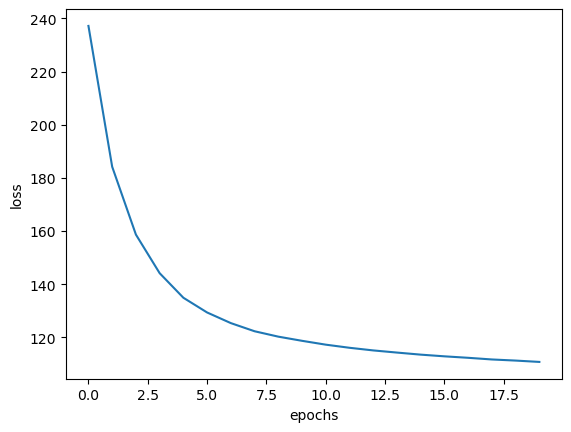

In [ ]:
# 訓練損失の表示
print(train_loss_list[-1])
plt.plot(train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## 5. 画像の再構成

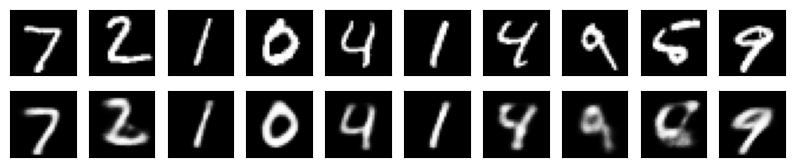

In [ ]:
# キャンバスサイズの設定
fig = plt.figure(figsize=(10, 3))

# テストデータの読み込み
x, t = next(iter(test_loader))
# 元画像を表示
for i, im in enumerate(x.view(-1, 28, 28).detach().clone().numpy()[:10]):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

# モデルをCPU/GPUモードに変更
model.to(device)
# モデルを推論モードに変更
model.eval()

# 再構成画像と潜在変数を出力
y, z = model(x.to(device))
y = y.view(-1, 28, 28)

# 画像を並べて表示
for i, im in enumerate(y.cpu().detach().clone().numpy()[:10]):
    ax = fig.add_subplot(3, 10, i + 11, xticks=[], yticks=[])
    ax.imshow(im, 'gray')